### Import libraries

In [ ]:
# Import necessary libraries
import pandas as pd
import os
from tqdm import tqdm
from hazm import Normalizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt

### ----------------------------------------
### Set Device (CPU or GPU)

In [ ]:
# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### ----------------------------------------
### Load Local Persian Sentiment Model

In [ ]:
# MODEL_NAME = "frameai/PersianSentiment"
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Path to the locally downloaded model
local_model_path = "../models/PersianSentiment/models--frameai--PersianSentiment"

# Load tokenizer and model from the local path
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
model = AutoModelForSequenceClassification.from_pretrained(local_model_path)

# Move model to the selected device (GPU or CPU)
model.to(device)
model.eval()  # Set model to evaluation mode

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-15): 16 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

### ----------------------------------------
### Define Text Preprocessing Function

In [ ]:
# Initialize Persian text normalizer
normalizer = Normalizer()

def preprocess(text):
    """
    Normalize and clean Persian text.
    """
    text = normalizer.normalize(str(text))
    text = " ".join(text.split())  # Remove extra whitespaces
    return text

### ----------------------------------------
### Define Batch Sentiment Prediction Function

In [ ]:
def predict_sentiments_batch(texts, batch_size=32):
    """
    Predict sentiments in batches to speed up processing.
    """
    results = []
    labels = ["negative", "positive", "neutral"]
    for i in tqdm(range(0, len(texts), batch_size), desc="Batch processing"):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k:v.to(device) for k,v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        labels_idx = torch.argmax(outputs.logits, dim=-1).cpu().tolist()
        results.extend([labels[idx] for idx in labels_idx])
    return results

### ----------------------------------------
### Setup Data Paths and Output Folder

In [ ]:
# Define paths to input data and output folder
data_path = "../data"
output_path = "../data/sentiment_results_batch"
os.makedirs(output_path, exist_ok=True)

# List all CSV files in the input data folder
csv_files = [f for f in os.listdir(data_path) if f.endswith(".csv")]


Processing bbcpersian_messages.csv...


Batch processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [02:53<00:00,  1.80it/s]


✅ Saved batch sentiment results to ../data/sentiment_results_batch/bbcpersian_messages.csv

Processing iranintlTV_messages.csv...


Batch processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:55<00:00,  1.77it/s]


✅ Saved batch sentiment results to ../data/sentiment_results_batch/iranintlTV_messages.csv

Processing kafiha_messages.csv...


Batch processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [02:52<00:00,  1.80it/s]


✅ Saved batch sentiment results to ../data/sentiment_results_batch/kafiha_messages.csv

Processing radiofarda_messages.csv...


Batch processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [02:58<00:00,  1.75it/s]


✅ Saved batch sentiment results to ../data/sentiment_results_batch/radiofarda_messages.csv

Processing TweetyChannel_messages.csv...


Batch processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [02:50<00:00,  1.80it/s]

✅ Saved batch sentiment results to ../data/sentiment_results_batch/TweetyChannel_messages.csv


### Process CSV Files and Predict Sentiments

In [ ]:
# Loop through all CSV files, preprocess, predict sentiments, and save results
for file in csv_files:
    print(f"\nProcessing {file}...")
    df = pd.read_csv(os.path.join(data_path, file))
    df['text'] = df['text'].apply(preprocess)
    
    sentiments = predict_sentiments_batch(df['text'].tolist(), batch_size=32)
    df['sentiment'] = sentiments
    
    output_file = os.path.join(output_path, file)
    df.to_csv(output_file, index=False, encoding="utf-8-sig")
    print(f"✅ Saved batch sentiment results to {output_file}")

### ----------------------------------------
### Plot Sentiment Distribution for Each CSV File

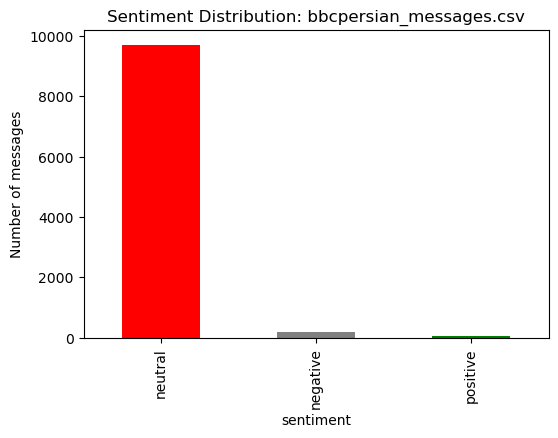

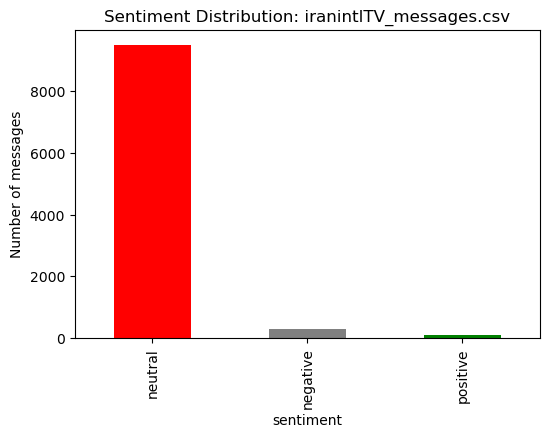

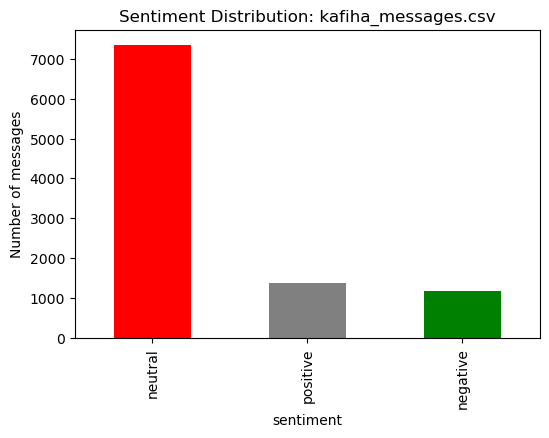

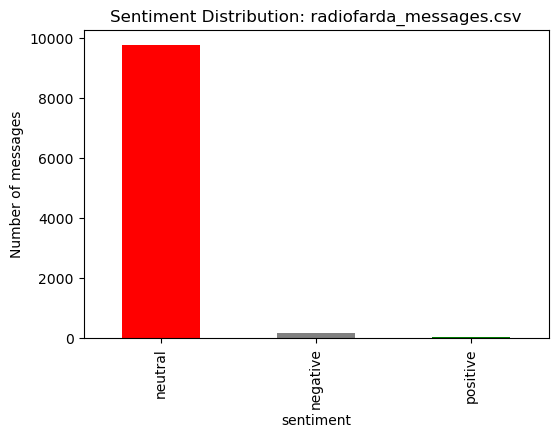

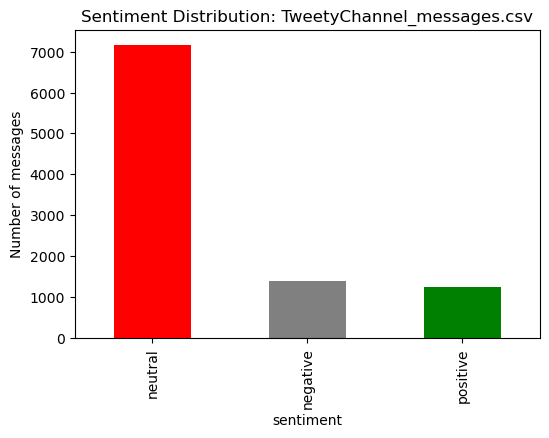

In [ ]:
# Plot the sentiment distribution for each processed CSV file
for file in csv_files:
    df = pd.read_csv(os.path.join(output_path, file))
    sentiment_counts = df['sentiment'].value_counts()
    
    plt.figure(figsize=(6,4))
    sentiment_counts.plot(kind='bar', color=['red','gray','green'])
    plt.title(f"Sentiment Distribution: {file}")
    plt.ylabel("Number of messages")
    plt.show()